## Load dataset

In [2]:
# chnage directory
path = "C:\\Users\\sin\\Desktop\\capstone_conocoPhillips"
import os
os.chdir(path)

In [251]:
#load the file
file_name =  "UT Comp_Seq.xlsx"
sheet =  1
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy import stats

comseq = pd.read_excel(io = file_name, sheet_name = 0)

## Clean Data
### 1. Remove Duplicate

In [4]:
df = comseq.copy()
# check for duplicate
dpl = sum(df.duplicated())
print("There is ",  dpl,  " duplicate") # no duplicate

There is  0  duplicate


### 2. Replace Na Values

#### Correlation 

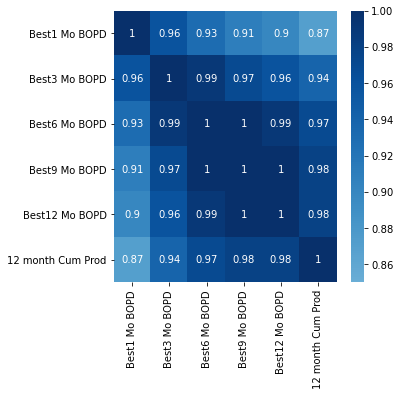

In [156]:
na_column = ['Best1 Mo BOPD', 'Best3 Mo BOPD', 'Best6 Mo BOPD',
       'Best9 Mo BOPD', 'Best12 Mo BOPD', '12 month Cum Prod']
corr_matrix = df[na_column].corr().round(2)
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, vmax=1, vmin=0.85, center=.85, cmap='Blues')
plt.show()

#### Association between variablee

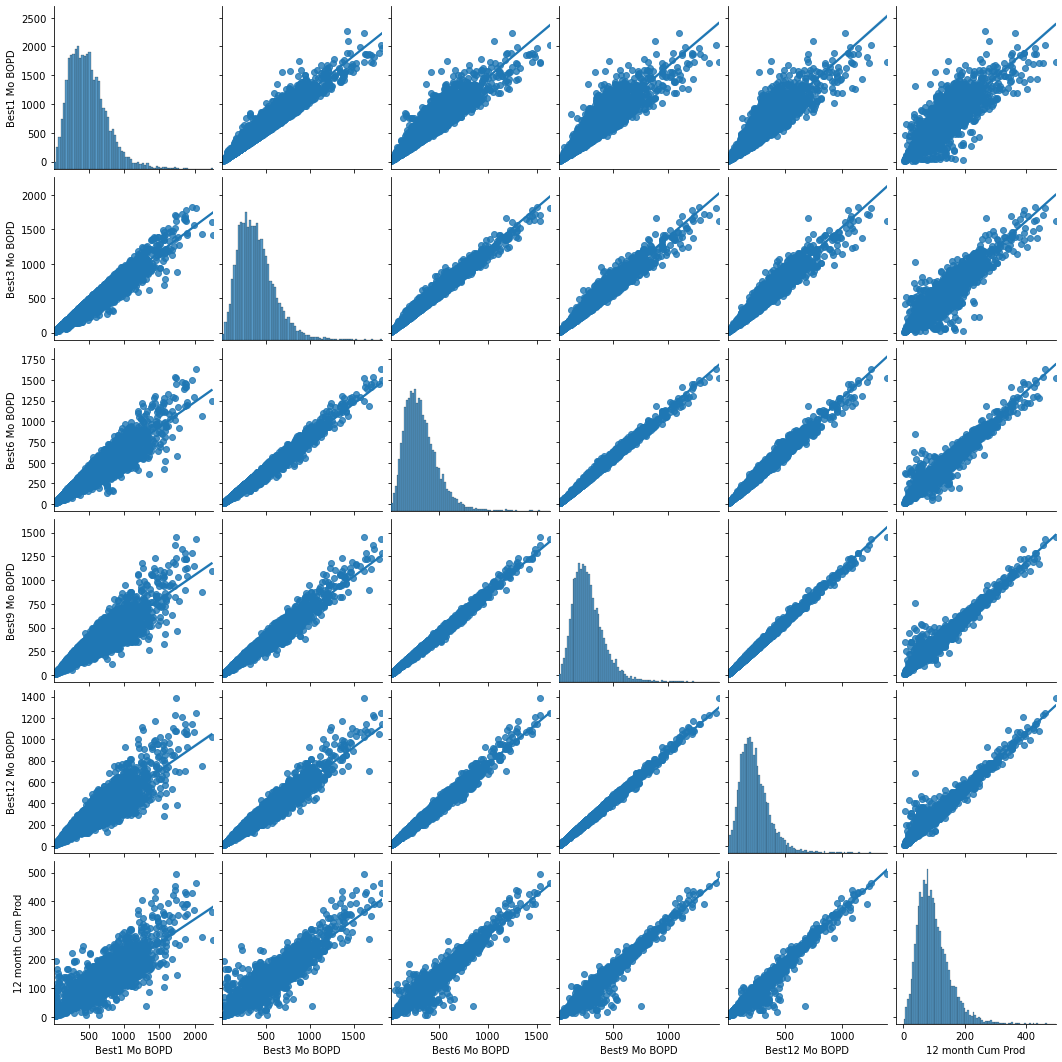

In [157]:
sns.pairplot(df[na_column], kind="reg")
plt.show()

#### Association between natural logarithmic variablee

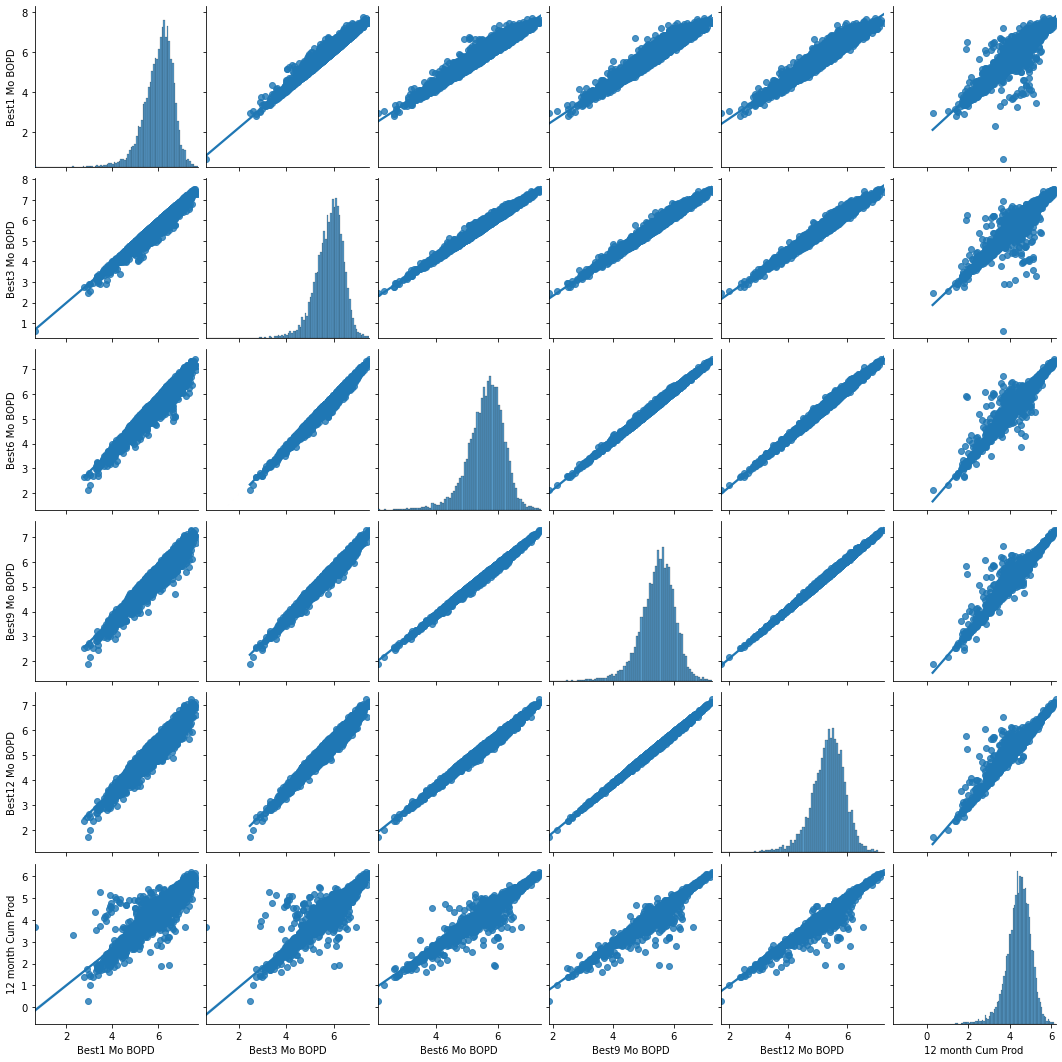

In [158]:
df_log = np.log(df[na_column])
sns.pairplot(df_log, kind="reg")
plt.show()

Because of non equal varience we use Natuarl Log 

#### Linear models for predicting Na valuse base on highest correlated varible

In [148]:
dflog_p01 = df_log[["Best1 Mo BOPD", "Best3 Mo BOPD"]].dropna()
model01 = LinearRegression().fit(dflog_p01["Best3 Mo BOPD"].values.reshape(-1,1),
                                dflog_p01["Best1 Mo BOPD"].values.reshape(-1,1))

In [149]:
dflog_p03 = df_log[["Best3 Mo BOPD", "Best6 Mo BOPD"]].dropna()
model03 = LinearRegression().fit(dflog_p03["Best6 Mo BOPD"].values.reshape(-1,1),
                                dflog_p03["Best3 Mo BOPD"].values.reshape(-1,1))

In [150]:
dflog_p06 = df_log[["Best6 Mo BOPD", "Best9 Mo BOPD"]].dropna()
model06 = LinearRegression().fit(dflog_p06["Best9 Mo BOPD"].values.reshape(-1,1),
                                dflog_p06["Best6 Mo BOPD"].values.reshape(-1,1))

In [153]:
dflog_p09 = df_log[["Best9 Mo BOPD", "Best12 Mo BOPD"]].dropna()
model09 = LinearRegression().fit(dflog_p09["Best12 Mo BOPD"].values.reshape(-1,1),
                                dflog_p09["Best9 Mo BOPD"].values.reshape(-1,1))

In [172]:
dflog_p12 = df_log[["Best12 Mo BOPD", "12 month Cum Prod"]].dropna()
model12 = LinearRegression().fit(dflog_p12["12 month Cum Prod"].values.reshape(-1,1),
                                dflog_p12["Best12 Mo BOPD"].values.reshape(-1,1))

# Apply each model to predecit the na valuse in each specific coloumn

In [193]:
df[na_column].isnull().sum()

Best1 Mo BOPD        1550
Best3 Mo BOPD        1656
Best6 Mo BOPD        2043
Best9 Mo BOPD        2464
Best12 Mo BOPD          0
12 month Cum Prod       0
dtype: int64

In [195]:
# Replace 'Best12 Mo BOPD' na values
df["pred_p12"] = np.exp(model12.predict(np.log(df["12 month Cum Prod"].values.reshape(-1,1))))
df["Best12 Mo BOPD"] = np.where(df["Best12 Mo BOPD"].isnull(),
                                df["pred_p12"],
                                df["Best12 Mo BOPD"])

In [196]:
# Replace "Best09 Mo BOPD" na values
df["pred_p9"] = np.exp(model09.predict(np.log(df["Best12 Mo BOPD"].values.reshape(-1,1))))
df["Best9 Mo BOPD"] = np.where(df["Best9 Mo BOPD"].isnull(),
                                df["pred_p9"],
                                df["Best9 Mo BOPD"])

In [197]:
# Replace "Best06 Mo BOPD" na values
df["pred_p6"] = np.exp(model06.predict(np.log(df["Best9 Mo BOPD"].values.reshape(-1,1))))
df["Best6 Mo BOPD"] = np.where(df["Best6 Mo BOPD"].isnull(),
                                df["pred_p6"],
                                df["Best6 Mo BOPD"])

In [198]:
# Replace "Best03 Mo BOPD" na values
df["pred_p3"] = np.exp(model03.predict(np.log(df["Best6 Mo BOPD"].values.reshape(-1,1))))
df["Best3 Mo BOPD"] = np.where(df["Best3 Mo BOPD"].isnull(),
                                df["pred_p3"],
                                df["Best3 Mo BOPD"])

In [199]:
# Replace "Best01 Mo BOPD" na values
df["pred_p1"] = np.exp(model01.predict(np.log(df["Best3 Mo BOPD"].values.reshape(-1,1))))
df["Best1 Mo BOPD"] = np.where(df["Best1 Mo BOPD"].isnull(),
                                df["pred_p1"],
                                df["Best1 Mo BOPD"])

In [203]:
df[na_column].isnull().sum()

Best1 Mo BOPD        0
Best3 Mo BOPD        0
Best6 Mo BOPD        0
Best9 Mo BOPD        0
Best12 Mo BOPD       0
12 month Cum Prod    0
dtype: int64

### Check Normality of "12 month Cum Prod"

#### Histogram Plot

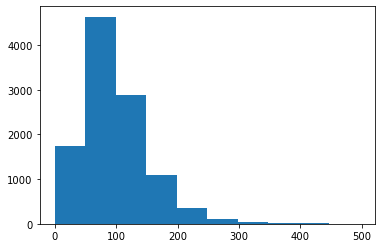

In [207]:
# histogram plot
plt.hist(df["12 month Cum Prod"])
plt.show()

#### qq-plot

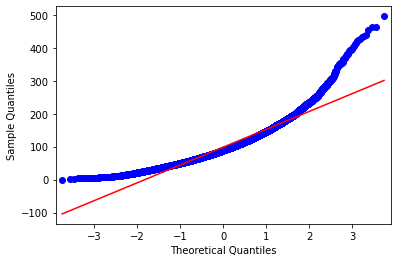

In [208]:
# QQ Plot
qqplot(df["12 month Cum Prod"], line='s')
plt.show()

#### Shapiro-Wilk Test

In [214]:
# Shapiro-Wilk Test
# normality test
stat, p = shapiro(df["12 month Cum Prod"])
print(p)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

0.0
Statistics=0.915, p=0.000
Sample does not look Gaussian (reject H0)


#### D’Agostino’s K^2 Test

In [215]:
# D'Agostino and Pearson's Test


stat, p = normaltest(df["12 month Cum Prod"])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=3143.467, p=0.000
Sample does not look Gaussian (reject H0)


## Check normality for logistic transformation  

In [216]:
# Shapiro-Wilk Test
# normality test
stat, p = shapiro(np.log(df["12 month Cum Prod"]))
print(p)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

5.605193857299268e-45
Statistics=0.965, p=0.000
Sample does not look Gaussian (reject H0)


In [9]:
# D'Agostino and Pearson's Test
from scipy.stats import normaltest

stat, p = normaltest(np.log(df["12 month Cum Prod"]))
print(p)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

0.0
Statistics=1739.089, p=0.000
Sample does not look Gaussian (reject H0)


## Completion type bar plot

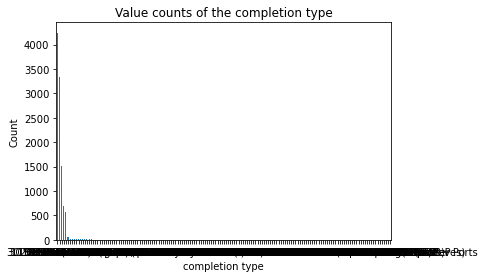

In [217]:
df["Compl. Type"].value_counts().plot(kind="bar")
plt.title("Value counts of the completion type")
plt.xlabel("completion type")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

In [218]:
# add the count of cumplType to dataframe
df['ComplType_counts'] = df.groupby(['Compl. Type'])['12 month Cum Prod'].transform('count')

In [219]:
ComplType_unique = df["ComplType_counts"].unique()
print(sorted(ComplType_unique,
            reverse = True))

[4244.0, 3340.0, 1503.0, 687.0, 565.0, nan, 52.0, 26.0, 22.0, 20.0, 18.0, 16.0, 13.0, 10.0, 8.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0]


In [220]:
# replce the ComplType_counts < 50 with "other" 
df['ComplType_new'] = np.where(df['ComplType_counts'] < 500 , "others", df['Compl. Type'])
df['ComplType_new'].value_counts(dropna = False)

Sleeves         4244
P & P           3340
P & P (cmt.)    1503
OH               687
No Data          565
others           427
NaN               90
Name: ComplType_new, dtype: int64

In [221]:
# replace the nan value with "No Data"
df["ComplType_new"] = np.where(df["ComplType_new"].isnull(), "No Data" , df["ComplType_new"])
df['ComplType_new'].value_counts(dropna = False)

Sleeves         4244
P & P           3340
P & P (cmt.)    1503
OH               687
No Data          655
others           427
Name: ComplType_new, dtype: int64

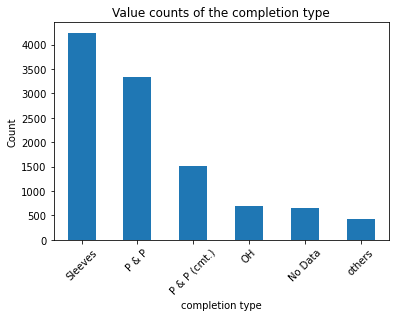

In [222]:
# bar plot again
df["ComplType_new"].value_counts().plot(kind="bar")
plt.title("Value counts of the completion type")
plt.xlabel("completion type")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

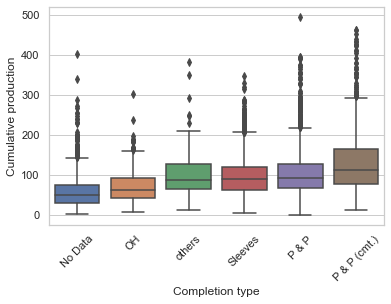

In [223]:
sns.set(style="whitegrid")
 
# Find the order
my_order = df.groupby(by=["ComplType_new"])["12 month Cum Prod"].median().sort_values().index

# Give it to the boxplot
sns.boxplot(x = 'ComplType_new',
            y = '12 month Cum Prod',
            data = df,
            order = my_order)
plt.xticks(rotation = 45)
plt.xlabel("Completion type")
plt.ylabel("Cumulative production")
plt.show()

 ## Kruskal Wallis test

In [225]:
cum_prod_OH = df[( df["ComplType_new"] == "OH")]["12 month Cum Prod"]
cum_prod_NoData = df[( df["ComplType_new"] == "No Data")]["12 month Cum Prod"]
cum_prod_others = df[( df["ComplType_new"] == "others")]["12 month Cum Prod"]
cum_prod_Sleeves = df[( df["ComplType_new"] == "Sleeves")]["12 month Cum Prod"]
cum_prod_PP = df[( df["ComplType_new"] == "P & P")]["12 month Cum Prod"]
cum_prod_PPcmt = df[( df["ComplType_new"] == "P & P (cmt.)")]["12 month Cum Prod"]

stats.kruskal(cum_prod_OH,
              cum_prod_NoData,
              cum_prod_others,
             cum_prod_Sleeves,
             cum_prod_PP,
             cum_prod_PPcmt)

KruskalResult(statistic=1009.8730072680648, pvalue=4.378962429294685e-216)

Since the p-value is small there is significantly difference between completion type groups. 

## One Way Anova test

In [227]:
stats.f_oneway(cum_prod_OH,
              cum_prod_NoData,
              cum_prod_others,
             cum_prod_Sleeves,
             cum_prod_PP,
             cum_prod_PPcmt)

F_onewayResult(statistic=208.92733643827995, pvalue=2.0938843992566383e-213)

Since the p-value is small there is significantly difference between completion type groups.

# Formation

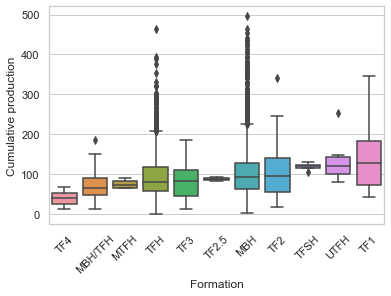

In [228]:
sns.set(style="whitegrid")
 
# Find the order
my_order = df.groupby(by=["Formation"])["12 month Cum Prod"].median().sort_values().index

# Give it to the boxplot
sns.boxplot(x = 'Formation',
            y = '12 month Cum Prod',
            data = df,
            order = my_order)
plt.xticks(rotation = 45)
plt.xlabel("Formation")
plt.ylabel("Cumulative production")
plt.show()

 ## Kruskal Wallis test

In [233]:
cum_prod_MBH = df[( df["Formation"] == "MBH")]["12 month Cum Prod"]
cum_prod_TFH = df[( df["Formation"] == "TFH")]["12 month Cum Prod"]
cum_prod_TF2 = df[( df["Formation"] == "TF2")]["12 month Cum Prod"]
cum_prod_TF3 = df[( df["Formation"] == "TF3")]["12 month Cum Prod"]
cum_prod_TF1 = df[( df["Formation"] == "TF1")]["12 month Cum Prod"]
cum_prod_MTFH = df[( df["Formation"] == "MTFH")]["12 month Cum Prod"]
cum_prod_UTFH = df[( df["Formation"] == "UTFH")]["12 month Cum Prod"]
cum_prod_TFSH = df[( df["Formation"] == "TFSH")]["12 month Cum Prod"]
cum_prod_TF4 = df[( df["Formation"] == "TF4")]["12 month Cum Prod"]
cum_prod_TF2_5 = df[( df["Formation"] == "TF2.5")]["12 month Cum Prod"]
cum_prod_MBHTFH = df[( df["Formation"] == "MBH/TFH")]["12 month Cum Prod"]


stats.kruskal(cum_prod_MBH,
              cum_prod_TFH,
              cum_prod_TF2,
              cum_prod_TF3,
              cum_prod_TF1,
              cum_prod_MTFH,
             cum_prod_UTFH,
             cum_prod_TFSH,
             cum_prod_TF4,
             cum_prod_TF2_5,
             cum_prod_MBHTFH)

KruskalResult(statistic=133.4052123040052, pvalue=9.423581974144481e-24)

Since the p-value is small there is significantly difference between Formation groups.

### One Way Anova

In [234]:
stats.f_oneway(cum_prod_MBH,
              cum_prod_TFH,
              cum_prod_TF2,
              cum_prod_TF3,
              cum_prod_TF1,
              cum_prod_MTFH,
             cum_prod_UTFH,
             cum_prod_TFSH,
             cum_prod_TF4,
             cum_prod_TF2_5,
             cum_prod_MBHTFH)

F_onewayResult(statistic=12.848641447201611, pvalue=1.3258871070206182e-22)

Since the p-value is small there is significantly difference between Formation groups.

## logistic regresion

In [236]:
x = df["12 month Cum Prod"]
y = df.ComplType_new
# splitting Data

x_train, x_test, y_train, y_test = train_test_split(x,
                 y,
                 test_size = .25,
                random_state = 483)
x_train = x_train.values.reshape(-1, 1)
x_test = x_test.values.reshape(-1, 1)

In [237]:
# instantiate the model (using the default parameters)
model_logreg = LogisticRegression(random_state = 483)

# fit the model with data
model_logreg.fit(x_train, y_train)    
y_pred = model_logreg.predict(x_test)

C:\Users\sin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [238]:
def scatterGeoWells(color):
    import plotly.express as px
    fig = px.scatter_geo(df,
                       lat='Latitude',
                       lon='Longitude',
                       color=color)
    
    fig.update_layout(title = 'Well locations' + " (" + color + ")",
                    title_x=0.5,
                    geo = dict(scope = "usa"))
    
    fig.update_geos(fitbounds="locations",
                  visible=True)
    return fig

## 12 month cumulative production 

In [239]:
scatterGeoWells("12 month Cum Prod").show()

## compare production in different time interval

In [240]:
def plotMapWells(c):
    fig = df.plot(kind="scatter",
              x="Longitude",
              y="Latitude",
              figsize=(10,7),
              label= c,
              c=c,
              cmap=plt.get_cmap("jet"),
              colorbar=True,
              alpha=0.4)

    plt.ylabel("Latitude", fontsize=14)
    plt.xlabel("Longitude", fontsize=14)
    plt.legend(fontsize=16)
    plt.show()

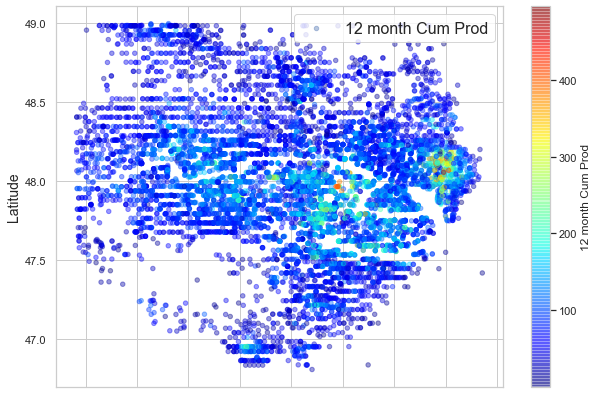

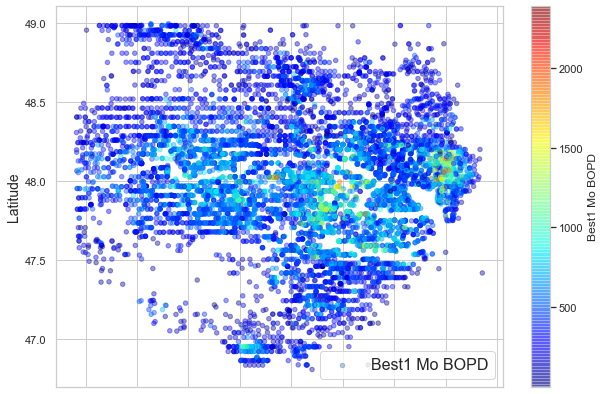

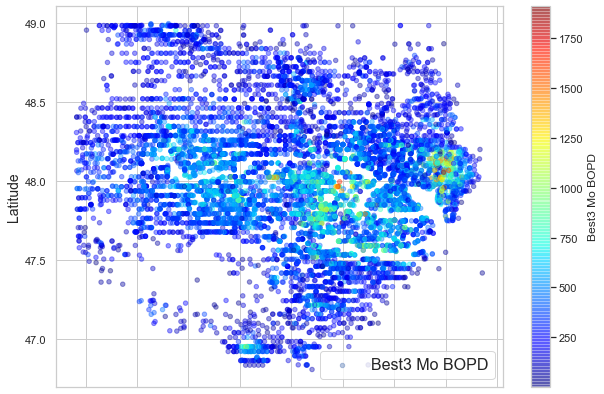

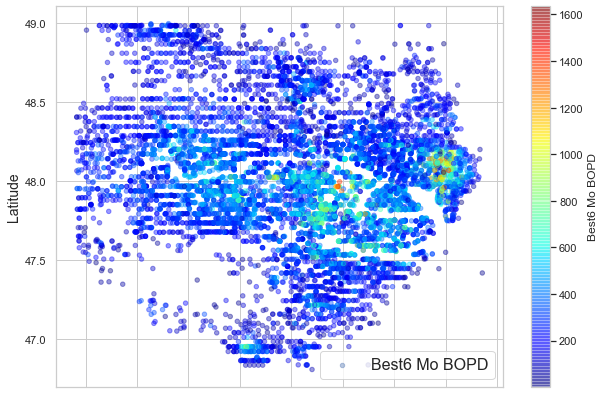

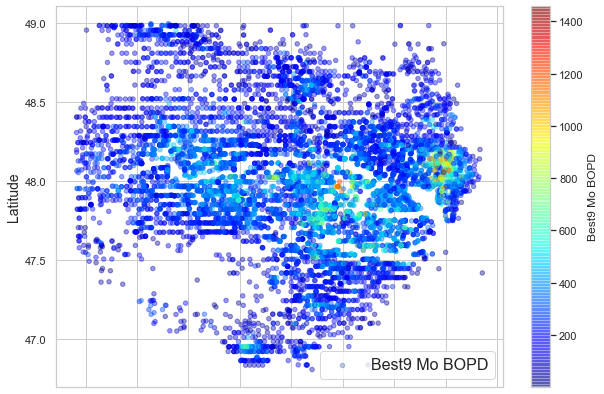

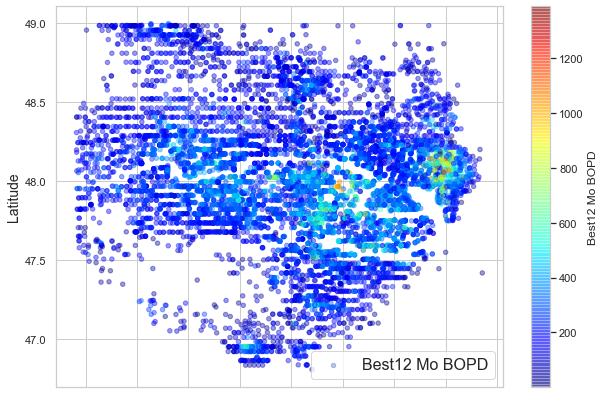

In [242]:
plotMapWells("12 month Cum Prod")
plotMapWells("Best1 Mo BOPD")
plotMapWells("Best3 Mo BOPD")
plotMapWells("Best6 Mo BOPD")
plotMapWells("Best9 Mo BOPD")
plotMapWells("Best12 Mo BOPD")

## Apply Decission Tree to predict the cumulative production base on location

In [252]:
y = df["12 month Cum Prod"]
x = df[["Latitude", "Longitude"]]
# splitting Data

x_train, x_test, y_train, y_test = train_test_split(x,
                 y,
                 test_size = .25,
                random_state = 483)
#x_train = x_train.values.reshape(-1, 1)
#x_test = x_test.values.reshape(-1, 1)

In [253]:

model = DecisionTreeRegressor(random_state=483)
model.fit(x_train, y_train)
pred = model.predict(x_test)

## Performance of the model (Root Square Mean Error)

In [254]:

rmse = np.sqrt(mean_squared_error(y_test, pred))
rmse

49.12587865259847

## Plot random location with predicted cumulative production

In [255]:
max_lat = df["Latitude"].max()
min_lat = df["Latitude"].min()
max_lon = df["Longitude"].max()
min_lon = df["Longitude"].min()

In [256]:
randon_location = {"Latitude": [],
                  "Longitude": []}
lat = np.linspace(min_lat, max_lat,  100)
lon = np.linspace(min_lon, max_lon,  100)

for i in lat:
    for j in lon:
        randon_location["Latitude"].append(i)
        randon_location["Longitude"].append(j)

In [257]:
randon_location = pd.DataFrame(randon_location)
pred_prod = model.predict(randon_location)

In [258]:
randon_location["12 month Cum Prod"] = pred_prod

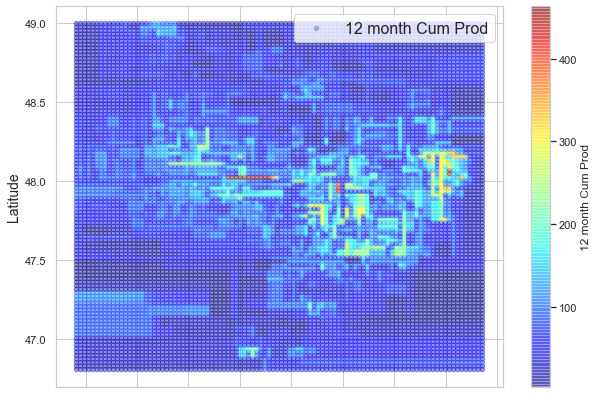

In [259]:
fig = randon_location.plot(kind="scatter",
              x="Longitude",
              y="Latitude",
              figsize=(10,7),
              label= "12 month Cum Prod",
              c="12 month Cum Prod",
              cmap=plt.get_cmap("jet"),
              colorbar=True,
              alpha=0.4)

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)
plt.show()

## Compare with True plot cumulative production

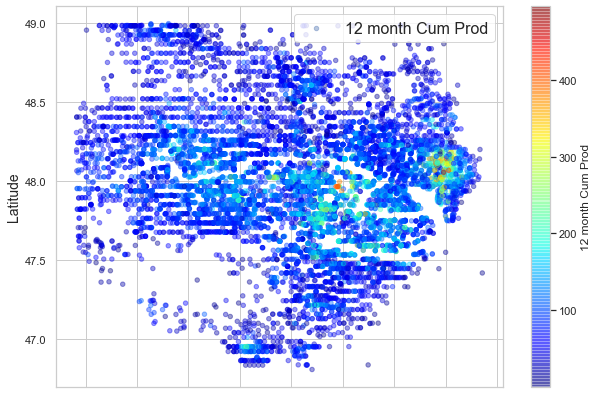

In [260]:
plotMapWells("12 month Cum Prod")

# Township

### Check for na 

In [267]:
print( "There is ", df["Township "].isnull().sum(), " NA value.")

There is  0  NA value.


In [268]:
df["Township "].unique()

array([143, 160, 142, 152, 156, 141, 147, 146, 144, 148, 145, 149, 153,
       151, 150, 155, 139, 154, 159, 161, 164, 157, 158, 140, 162, 163],
      dtype=int64)

In [296]:
df.groupby(by=["Township "])["12 month Cum Prod"].mean().nlargest(5)

Township 
152    125.443363
150    124.001244
153    119.567673
151    115.265792
147    114.016368
Name: 12 month Cum Prod, dtype: float64

In [297]:
df.groupby(by=["Township "])["Best1 Mo BOPD"].mean().nlargest(5)

Township 
152    677.900602
150    659.135922
151    608.975349
147    605.028789
153    603.951052
Name: Best1 Mo BOPD, dtype: float64

In [298]:
df.groupby(by=["Township "])["Best3 Mo BOPD"].mean().nlargest(5)

Township 
152    544.357210
150    534.044304
151    494.018560
153    490.288805
147    479.949200
Name: Best3 Mo BOPD, dtype: float64

In [299]:
df.groupby(by=["Township "])["Best6 Mo BOPD"].mean().nlargest(5)

Township 
152    442.714595
150    437.954618
153    408.110869
151    405.545798
147    395.336410
Name: Best6 Mo BOPD, dtype: float64

In [300]:
df.groupby(by=["Township "])["Best9 Mo BOPD"].mean().nlargest(5)

Township 
152    380.264904
150    375.213087
153    358.747491
151    349.978929
147    341.685648
Name: Best9 Mo BOPD, dtype: float64

In [301]:
df.groupby(by=["Township "])["Best12 Mo BOPD"].mean().nlargest(5)

Township 
152    337.692235
150    333.114862
153    321.253605
151    311.075737
147    305.412036
Name: Best12 Mo BOPD, dtype: float64

In [304]:
df.groupby(by=["Township "])["Best12 Mo BOPD"].mean().nlargest(5)

Township 
152    337.692235
150    333.114862
153    321.253605
151    311.075737
147    305.412036
Name: Best12 Mo BOPD, dtype: float64

152, 150, 153, 151, 147 are the highest Township categories.

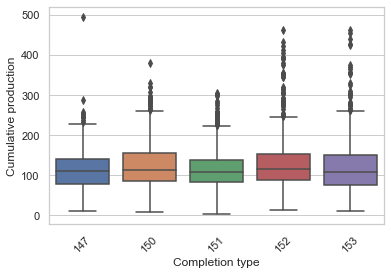

In [325]:
sns.set(style="whitegrid")
 
# Find the order
list_top5_township = [152, 150, 153, 151, 147]
df_top5_township = df[df["Township "].isin(list_top5_township)]
# Give it to the boxplot
sns.boxplot(x = 'Township ',
            y = '12 month Cum Prod',
            data = df_top5_township)

plt.xticks(rotation = 45)
plt.xlabel("Township type")
plt.ylabel("Cumulative production")
plt.show()